In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import cuda
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import Dataset
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

# Configuration de l'appareil
device = 'cuda' if cuda.is_available() else 'cpu'

# Chemin des données et des résultats
data_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/raw/initial_training_data.csv"
output_dir = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/transformers/distilbert/token_classification"
os.makedirs(output_dir, exist_ok=True)

# Chargement et mélange du jeu de données initial
data = pd.read_csv(data_path)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Réduction du jeu de données à 30% de sa taille initiale
data_reduced = data.sample(frac=0.3, random_state=42)

# Division des données pour l'entraînement, la validation et le test
train_data, temp_data = train_test_split(data_reduced, test_size=0.25, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.7, random_state=42)

print(f"Taille du jeu de données d'entraînement: {len(train_data)}")
print(f"Taille du jeu de données de validation: {len(valid_data)}")
print(f"Taille du jeu de données de test: {len(test_data)}")

# Transformation des colonnes `tokens` et `ner_tags` en listes
train_data['tokens'] = train_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
train_data['ner_tags'] = train_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
valid_data['tokens'] = valid_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
valid_data['ner_tags'] = valid_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
test_data['tokens'] = test_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
test_data['ner_tags'] = test_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Extraction dynamique des étiquettes
all_labels = set()
for entities in train_data['ner_tags']:
    for entity in entities:
        all_labels.add(entity['label'])

# Création de la liste des étiquettes
label_list = ["O"] + sorted(all_labels)
print(f"Liste des étiquettes trouvées : {label_list}")
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

# Chargement du tokenizer pour DistilBERT
model_checkpoint = "distilbert-base-uncased"  # Changement de Camembert à DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Fonction de Tokenisation et d'Alignement des Étiquettes
def tokenize_and_align_labels(data):
    tokenized_inputs = tokenizer(
        data['tokens'].tolist(),
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_tensors="pt"
    )
    labels = []
    for i, entities in enumerate(data['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100] * len(word_ids)  # -100 is used to ignore padding tokens
        for entity in entities:
            start_idx, end_idx, tag = entity['start'], entity['end'], entity['label']
            token_start, token_end = None, None
            for idx, word_id in enumerate(word_ids):
                # Compare token positions with the start and end positions
                if word_id is not None:
                    token_start_pos = len(" ".join(data['tokens'].tolist()[i][:word_id]))
                    token_end_pos = token_start_pos + len(data['tokens'].tolist()[i][word_id])

                    # Check if the word's start and end are within the entity's bounds
                    if start_idx >= token_start_pos and token_start is None:
                        token_start = idx
                    if end_idx <= token_end_pos and token_end is None:
                        token_end = idx
                        break

            if token_start is not None and token_end is not None and tag in label2id:
                label_ids[token_start:token_end + 1] = [label2id[tag]] * (token_end - token_start + 1)
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Assurez-vous que les entrées sont correctement tokenisées et les labels alignés
tokenized_train = tokenize_and_align_labels(train_data)
tokenized_valid = tokenize_and_align_labels(valid_data)
tokenized_test = tokenize_and_align_labels(test_data)

train_dataset = Dataset.from_dict(tokenized_train)
valid_dataset = Dataset.from_dict(tokenized_valid)
test_dataset = Dataset.from_dict(tokenized_test)

# Chargement du modèle DistilBERT pour la classification de tokens
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_steps=500,
    logging_dir=os.path.join(output_dir, "logs"),
)

# Entraînement du modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
)

trainer.train()
trainer.save_model(output_dir)

# Évaluation sur le jeu de test
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids

# Extraction des entités et des prédictions
def extract_entities(predictions, labels, id2label):
    entities, flat_predictions, flat_labels = [], [], []
    for i in range(len(predictions)):
        current_entity = {"group": None, "city": ""}
        for j in range(len(predictions[i])):
            # Ignore padding tokens
            if predictions[i][j] != -100 and labels[i][j] != -100:
                flat_predictions.append(predictions[i][j])
                flat_labels.append(labels[i][j])

                # Reconnaître les entités en fonction des labels
                label = id2label[flat_predictions[-1]]
                token = tokenizer.convert_ids_to_tokens(predictions[i][j])  # Changement ici

                # Si nous rencontrons une nouvelle entité, nous la commençons
                if "LOC" in label:  # Lieux
                    if token.startswith("▁"):  # Indicateur de début de mot dans CamemBERT
                        if current_entity["city"]:  # Si une entité précédente existe, l'ajouter
                            entities.append(current_entity)
                        current_entity = {"group": "LOC", "city": token.lstrip("▁")}
                    else:
                        current_entity["city"] += token  # Ajouter les sous-tokens à l'entité en cours
                elif "PER" in label or "ORG" in label:  # Si c'est une personne ou une organisation
                    if token.startswith("▁"):
                        if current_entity["city"]:
                            entities.append(current_entity)
                        current_entity = {"group": label, "city": token.lstrip("▁")}
                    else:
                        current_entity["city"] += token
                elif current_entity["city"]:  # Si nous avons une entité en cours mais le label est "O" (hors entité)
                    entities.append(current_entity)
                    current_entity = {"group": None, "city": ""}

        # Si une entité est toujours en cours à la fin de la phrase, on l'ajoute
        if current_entity["city"]:
            entities.append(current_entity)

    return entities, flat_predictions, flat_labels

flat_predictions, flat_labels = extract_entities(predicted_labels, labels, id2label)

# Vérification des classes présentes
present_classes = sorted(set(flat_predictions) | set(flat_labels))
target_names = [label_list[i] for i in present_classes]

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(flat_labels, flat_predictions, labels=present_classes)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names)
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

# Affichage du rapport de classification
print(classification_report(flat_labels, flat_predictions, target_names=target_names))


Taille du jeu de données d'entraînement: 48
Taille du jeu de données de validation: 5
Taille du jeu de données de test: 12
Liste des étiquettes trouvées : ['O', 'DEPARTURE', 'DESTINATION', 'ESCALE']


C:\Users\vikne\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vikne\anaconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9829533696174622, 'eval_runtime': 0.3006, 'eval_samples_per_second': 16.632, 'eval_steps_per_second': 3.326, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.8611953854560852, 'eval_runtime': 0.2041, 'eval_samples_per_second': 24.502, 'eval_steps_per_second': 4.9, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7625371813774109, 'eval_runtime': 0.2573, 'eval_samples_per_second': 19.43, 'eval_steps_per_second': 3.886, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6641433835029602, 'eval_runtime': 0.2016, 'eval_samples_per_second': 24.801, 'eval_steps_per_second': 4.96, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6290455460548401, 'eval_runtime': 0.1918, 'eval_samples_per_second': 26.073, 'eval_steps_per_second': 5.215, 'epoch': 5.0}
{'train_runtime': 52.7914, 'train_samples_per_second': 4.546, 'train_steps_per_second': 0.284, 'train_loss': 0.8679677327473958, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

TypeError: 'numpy.int64' object is not iterable

Taille du jeu de données d'entraînement: 48
Taille du jeu de données de validation: 5
Taille du jeu de données de test: 12
Liste des étiquettes trouvées : ['O', 'DEPARTURE', 'DESTINATION', 'ESCALE']


C:\Users\vikne\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\vikne\anaconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9829533696174622, 'eval_runtime': 0.2313, 'eval_samples_per_second': 21.617, 'eval_steps_per_second': 4.323, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.8611953854560852, 'eval_runtime': 0.2055, 'eval_samples_per_second': 24.325, 'eval_steps_per_second': 4.865, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7625371813774109, 'eval_runtime': 0.1915, 'eval_samples_per_second': 26.108, 'eval_steps_per_second': 5.222, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6641433835029602, 'eval_runtime': 0.1738, 'eval_samples_per_second': 28.772, 'eval_steps_per_second': 5.754, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.6290455460548401, 'eval_runtime': 0.176, 'eval_samples_per_second': 28.413, 'eval_steps_per_second': 5.683, 'epoch': 5.0}
{'train_runtime': 37.4681, 'train_samples_per_second': 6.405, 'train_steps_per_second': 0.4, 'train_loss': 0.8679677327473958, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

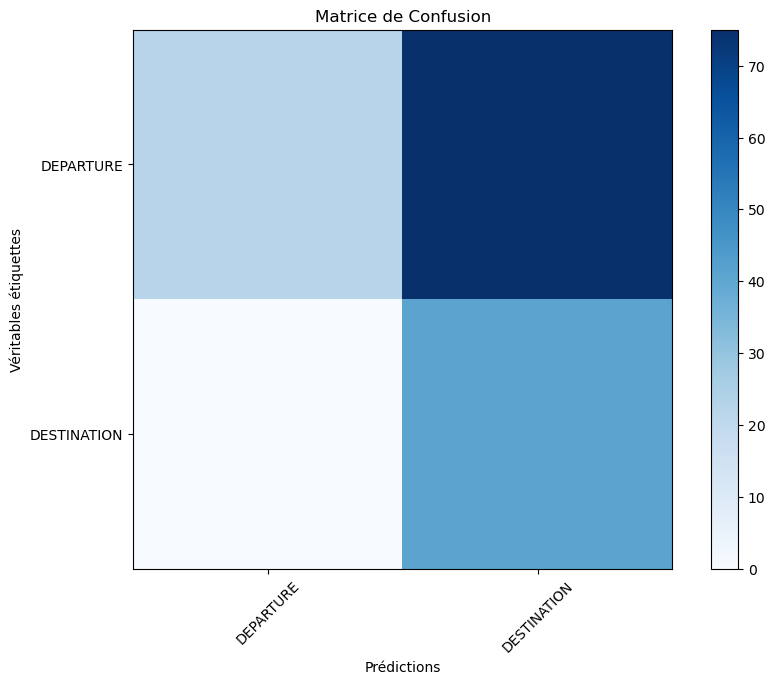

              precision    recall  f1-score   support

   DEPARTURE       1.00      0.23      0.37        97
 DESTINATION       0.35      1.00      0.52        41

    accuracy                           0.46       138
   macro avg       0.68      0.61      0.45       138
weighted avg       0.81      0.46      0.42       138



In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch import cuda
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import Dataset
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

# Configuration de l'appareil
device = 'cuda' if cuda.is_available() else 'cpu'

# Chemin des données et des résultats
data_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/raw/initial_training_data.csv"
output_dir = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/transformers/distilbert/token_classification"
os.makedirs(output_dir, exist_ok=True)

# Chargement et mélange du jeu de données initial
data = pd.read_csv(data_path)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Réduction du jeu de données à 30% de sa taille initiale
data_reduced = data.sample(frac=0.3, random_state=42)

# Division des données pour l'entraînement, la validation et le test
train_data, temp_data = train_test_split(data_reduced, test_size=0.25, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.7, random_state=42)

print(f"Taille du jeu de données d'entraînement: {len(train_data)}")
print(f"Taille du jeu de données de validation: {len(valid_data)}")
print(f"Taille du jeu de données de test: {len(test_data)}")

# Transformation des colonnes `tokens` et `ner_tags` en listes
train_data['tokens'] = train_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
train_data['ner_tags'] = train_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
valid_data['tokens'] = valid_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
valid_data['ner_tags'] = valid_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
test_data['tokens'] = test_data['text'].apply(lambda x: x.split() if isinstance(x, str) else [])
test_data['ner_tags'] = test_data['entities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Extraction dynamique des étiquettes
all_labels = set()
for entities in train_data['ner_tags']:
    for entity in entities:
        all_labels.add(entity['label'])

# Création de la liste des étiquettes
label_list = ["O"] + sorted(all_labels)
print(f"Liste des étiquettes trouvées : {label_list}")
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

# Chargement du tokenizer pour DistilBERT
model_checkpoint = "distilbert-base-uncased"  # Changement de Camembert à DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Fonction de Tokenisation et d'Alignement des Étiquettes
def tokenize_and_align_labels(data):
    tokenized_inputs = tokenizer(
        data['tokens'].tolist(),
        truncation=True,
        is_split_into_words=True,
        padding=True,
        return_tensors="pt"
    )
    labels = []
    for i, entities in enumerate(data['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100] * len(word_ids)  # -100 is used to ignore padding tokens
        for entity in entities:
            start_idx, end_idx, tag = entity['start'], entity['end'], entity['label']
            token_start, token_end = None, None
            for idx, word_id in enumerate(word_ids):
                # Compare token positions with the start and end positions
                if word_id is not None:
                    token_start_pos = len(" ".join(data['tokens'].tolist()[i][:word_id]))
                    token_end_pos = token_start_pos + len(data['tokens'].tolist()[i][word_id])

                    # Check if the word's start and end are within the entity's bounds
                    if start_idx >= token_start_pos and token_start is None:
                        token_start = idx
                    if end_idx <= token_end_pos and token_end is None:
                        token_end = idx
                        break

            if token_start is not None and token_end is not None and tag in label2id:
                label_ids[token_start:token_end + 1] = [label2id[tag]] * (token_end - token_start + 1)
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Assurez-vous que les entrées sont correctement tokenisées et les labels alignés
tokenized_train = tokenize_and_align_labels(train_data)
tokenized_valid = tokenize_and_align_labels(valid_data)
tokenized_test = tokenize_and_align_labels(test_data)

train_dataset = Dataset.from_dict(tokenized_train)
valid_dataset = Dataset.from_dict(tokenized_valid)
test_dataset = Dataset.from_dict(tokenized_test)

# Chargement du modèle DistilBERT pour la classification de tokens
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_steps=500,
    logging_dir=os.path.join(output_dir, "logs"),
)

# Entraînement du modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    tokenizer=tokenizer,
)

trainer.train()
trainer.save_model(output_dir)

# Évaluation sur le jeu de test
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids

# Extraction des entités et des prédictions
def extract_entities(predictions, labels, id2label):
    entities, flat_predictions, flat_labels = [], [], []
    for i in range(len(predictions)):
        current_entity = {"group": None, "city": ""}
        for j in range(len(predictions[i])):
            # Ignore padding tokens
            if predictions[i][j] != -100 and labels[i][j] != -100:
                flat_predictions.append(predictions[i][j])
                flat_labels.append(labels[i][j])

                # Reconnaître les entités en fonction des labels
                label = id2label[flat_predictions[-1]]
                
                # Assurez-vous que l'élément est un seul entier
                token_id = predictions[i][j]
                token = tokenizer.convert_ids_to_tokens(int(token_id))  # Conversion de l'ID en token

                # Si nous rencontrons une nouvelle entité, nous la commençons
                if "LOC" in label:  # Lieux
                    if token.startswith("▁"):  # Indicateur de début de mot dans CamemBERT
                        if current_entity["city"]:  # Si une entité précédente existe, l'ajouter
                            entities.append(current_entity)
                        current_entity = {"group": "LOC", "city": token.lstrip("▁")}
                    else:
                        current_entity["city"] += token  # Ajouter les sous-tokens à l'entité en cours
                elif "PER" in label or "ORG" in label:  # Si c'est une personne ou une organisation
                    if token.startswith("▁"):
                        if current_entity["city"]:
                            entities.append(current_entity)
                        current_entity = {"group": label, "city": token.lstrip("▁")}
                    else:
                        current_entity["city"] += token
                elif current_entity["city"]:  # Si nous avons une entité en cours mais le label est "O" (hors entité)
                    entities.append(current_entity)
                    current_entity = {"group": None, "city": ""}

        # Si une entité est toujours en cours à la fin de la phrase, on l'ajoute
        if current_entity["city"]:
            entities.append(current_entity)

    return entities, flat_predictions, flat_labels

# Appel à la fonction et déballage des trois valeurs retournées
entities, flat_predictions, flat_labels = extract_entities(predicted_labels, labels, id2label)

# Vérification des classes présentes

# Vérification des classes présentes
present_classes = sorted(set(flat_predictions) | set(flat_labels))
target_names = [label_list[i] for i in present_classes]

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(flat_labels, flat_predictions, labels=present_classes)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de Confusion")
plt.colorbar()
plt.xticks(np.arange(len(target_names)), target_names, rotation=45)
plt.yticks(np.arange(len(target_names)), target_names)
plt.xlabel('Prédictions')
plt.ylabel('Véritables étiquettes')
plt.show()

# Affichage du rapport de classification
print(classification_report(flat_labels, flat_predictions, target_names=target_names))


In [22]:
import torch

# Fonction pour tester le modèle avec une nouvelle phrase
def predict_entities_on_text(texts, tokenizer, model, label2id, id2label):
    # Tokenisation des phrases
    encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", is_split_into_words=False)

    # Faire des prédictions avec le modèle
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

    # Convertir les prédictions en entités
    entities = []
    for i, text in enumerate(texts):
        predicted_labels = predictions[i].tolist()
        tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'][i])

        # Extraction des entités
        current_entity = {"group": None, "city": ""}
        for j, label_id in enumerate(predicted_labels):
            label = id2label[label_id]
            token = tokens[j]

            if label != "O":  # Si ce n'est pas une entité "O" (hors entité)
                # Si nous rencontrons une nouvelle entité
                if "LOC" in label:  # Lieux
                    if token.startswith(" "):
                        if current_entity["city"]:
                            entities.append(current_entity)
                        current_entity = {"group": "LOC", "city": token.lstrip(" ")}
                    else:
                        current_entity["city"] += token  # Ajouter les sous-tokens à l'entité en cours
                elif "PER" in label or "ORG" in label:  # Personne ou Organisation
                    if token.startswith(" "):
                        if current_entity["city"]:
                            entities.append(current_entity)
                        current_entity = {"group": label, "city": token.lstrip(" ")}
                    else:
                        current_entity["city"] += token
            elif current_entity["city"]:  # Si nous avons une entité en cours mais le label est "O" (hors entité)
                entities.append(current_entity)
                current_entity = {"group": None, "city": ""}

        # Si une entité est toujours en cours à la fin de la phrase
        if current_entity["city"]:
            entities.append(current_entity)

    return entities

# Exemple de phrases à tester
test_phrases = [
    "John Doe went to Paris last summer.",
    "Apple is opening a new store in New York City.",
    "The Eiffel Tower is located in Paris."
]

# Appel à la fonction pour prédire les entités
predicted_entities = predict_entities_on_text(test_phrases, tokenizer, model, label2id, id2label)

# Affichage des résultats
for i, phrase in enumerate(test_phrases):
    print(f"\nPhrase: {phrase}")
    print("Entités détectées:")
    if i < len(predicted_entities):
        for entity in predicted_entities[i]:
            print(f"  - {entity['group']}: {entity['city']}")
    else:
        print("  - Aucune entité détectée.")



Phrase: John Doe went to Paris last summer.
Entités détectées:
  - Aucune entité détectée.

Phrase: Apple is opening a new store in New York City.
Entités détectées:
  - Aucune entité détectée.

Phrase: The Eiffel Tower is located in Paris.
Entités détectées:
  - Aucune entité détectée.
